# Type-token ratio in Universal Dependencies treebanks

For measuring the degree of synthesis in a language, the type-token ratio has been used as a sort of latent variable. The assumption is that languages with a high degree of synthesis will have a higher type/token ratio.

Here, we calculate the ratio for all languages available in the UD treebanks (1.1).

In [1]:
%matplotlib inline
treebank_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-1/ud-treebanks-v1.1"

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../tools/')
import udtree

import pandas as pd

from os import listdir
from os.path import join
from collections import defaultdict

# Extract treebank paths. Lists are necessary since Czech has multiple files.
train_files = {'UD_Basque': ['eu-ud-train.conllu'], 
              'UD_Croatian': ['hr-ud-train.conllu'], 
              'UD_Danish': ['da-ud-train.conllu'], 
              'UD_Finnish': ['fi-ud-train.conllu'], 
              'UD_French': ['fr-ud-train.conllu'], 
              'UD_Greek': ['el-ud-train.conllu'], 
              'UD_Hungarian': ['hu-ud-train.conllu'], 
              'UD_Irish': ['ga-ud-train.conllu'], 
              'UD_Persian': ['fa-ud-train.conllu'], 
              'UD_Swedish': ['sv-ud-train.conllu'], 
              'UD_Bulgarian': ['bg-ud-train.conllu'], 
              'UD_Czech': ['cs-ud-train-c.conllu',
                           'cs-ud-train-m.conllu',
                           'cs-ud-train-v.conllu',
                           'cs-ud-train-l.conllu'], 
              'UD_English': ['en-ud-train.conllu'], 
              'UD_Finnish-FTB': ['fi_ftb-ud-train.conllu'], 
              'UD_German': ['de-ud-train.conllu'], 
              'UD_Hebrew': ['he-ud-train.conllu'], 
              'UD_Indonesian': ['id-ud-train.conllu'], 
              'UD_Italian': ['it-ud-train.conllu'], 
              'UD_Spanish': ['es-ud-train.conllu']}

# UD_Language: [filepaths]
treebanks = {f: [join(treebank_path, f, train_file) for train_file in train_files[f]]
             for f in listdir(treebank_path) 
             if f.startswith("UD_")}  # remove hidden files

In [2]:
def calculate_ttr(trees):
    words = defaultdict(int)
    for tree in trees:
        for word in tree.words:
            words[word] += 1
    
    return sum(words.values()) / len(words)

In [3]:
token_type_ratio = {}
for language, treebank in treebanks.items():
    token_type_ratio[language] = calculate_ttr(udtree.from_files(treebank))

ttr = pd.Series(token_type_ratio).sort_values()

## TTR results on training set

In [6]:
ttr

UD_Hungarian       2.554312
UD_Finnish-FTB     3.016516
UD_Basque          3.142131
UD_Finnish         3.310433
UD_Irish           3.490282
UD_Bulgarian       4.529049
UD_Greek           4.595545
UD_Croatian        4.651343
UD_Danish          5.029253
UD_Indonesian      5.073662
UD_Swedish         5.161877
UD_German          5.451285
UD_Hebrew          8.167822
UD_Spanish         8.275111
UD_French          8.454864
UD_Persian         9.114223
UD_Czech           9.360645
UD_Italian         9.387541
UD_English        10.410442
dtype: float64

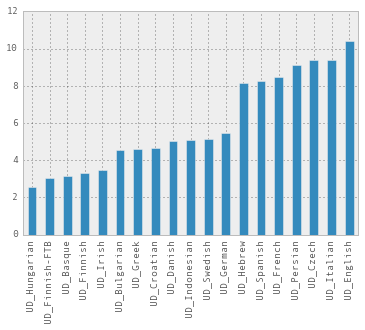

In [8]:
ttr.plot(kind='bar')

The TTR order of the UD treebank languages seem to somewhat follow the intuition, where English as a highly isolated language is ranked highest, while Hungarian Finnish, and Basque are at the bottom. One clear outlier is Czech, which as a highly fusional language should have a much lower ratio. After investigation I realized that since the Czech training data is an order of magnitude larger than all other data, the type/token ratio naturally becomes much lower. This has been verified by others as well [[1]](http://link.springer.com/article/10.1007%2Fs11185-015-9151-8#).

# Standardised TTR

While [1] suggests a new measurement, zTTR, it seems a bit more difficult to implement so I'll just settle with Standardized TTR (sTTR) for now, which is the average TTR over chunked input of 1000 words.

In [10]:
def calculate_chunked_ttr(trees):
    max_chunk_size = 1000
    chunks = [defaultdict(int)]
    chunk_size = 0
    for tree in trees:
        for token in tree.tokens:
            if chunk_size > max_chunk_size:
                chunks.append(defaultdict(int))
                chunk_size = 0
            chunks[-1][token] += 1
            chunk_size += 1
    
    ttrs = map(lambda tokens: sum(tokens.values()) / len(tokens), chunks)
    return ttrs

token_type_ratio = {}
for language, treebank in treebanks.items():
    series = pd.Series(calculate_chunked_ttr(udtree.from_files(treebank)))
    token_type_ratio[language] = pd.Series({'mean': series.mean(), 'std_deviation': series.std()})


In [13]:
ttr = pd.concat(token_type_ratio, axis=1).transpose().sort_values('mean')
ttr.to_csv('../data/standard_ttr.1.1.csv')
ttr

,mean,std_deviation
UD_Finnish-FTB,1.519148,0.102774
UD_Basque,1.569597,0.036438
UD_Finnish,1.601419,0.174828
UD_Czech,1.666643,0.116945
UD_Indonesian,1.688530,0.046713
UD_Hebrew,1.701824,0.079374
UD_German,1.732144,0.078641
UD_Hungarian,1.736633,0.067214
UD_Greek,1.807905,0.052342
UD_Croatian,1.809131,0.082703


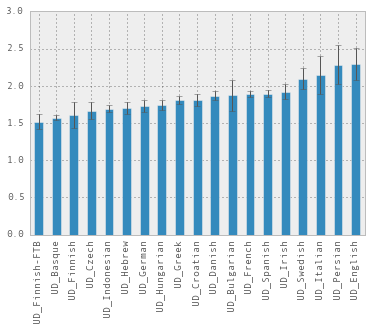

In [12]:
ttr['mean'].plot(kind='bar', yerr=ttr['std_deviation'])

This looks much better. The standard deviation is somewhat higher for Finnish, Bulgarian, Italian, Persian, and English. It doesn't seem to correlate with the their domains according to UD docs. In any case, the std deviations aren't high enough to alter the results significantly.

# Conclusion

sTTR is a better measurement, due to the training data being of such different sizes. The results of sTTR are much more intuitive given the typological differences we are interested of (at least of the languages that I have some knowledge of). Given the results, I'm confident we can use the sTTR measurement as a reference when looking at the distribution of function dependencies across languages.